This notebook creates synthetic displacement time series (same rate, random noise added for nn iterations) and does an inversion with made-up coherence values. In addition to adding noise associated with each date (affecting two igrams), I add noise associated with each igram (only affecting one) on one date, to simulate speckle/decorrelation rather than atmospheric noise. 

This notebook: <br>
1. creates displacement data (single time series) by adding noise to a constant velocity time series (line). This has irregularly-sampled time intervals to show that it works without constant dt.
2. makes coherence values to accompany the data, one value has higher error/standard deviation 
3. creates covariance matrix using noise levels defined above plus noise associated with one interferogram (speckle)
4. Inverts using the disp over time method.
5. Plots everything.

This notebook was written on 12-19-22. Most recently edited 1-26-23.

***

In [7]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
%matplotlib  widget

Create synthetic data.

In [8]:
nd = 10                     # number of dates
V = 3                       # velocity 
Sig = 0.5*np.ones((nd,))    # noise std. dev vector 
print(np.shape(Sig))
Sig[7] = 5.0                  # bigger noise on the 9th date
print('Variances/Sigs: '+str(Sig))
Sigm = np.diag(Sig,0)       # same as Cd?
print('Sigm: \n'+str(Sigm))
# Make an array of dates, with first time interval twice as long as the others.
# this shows that the approach doesn't require constant time intervals.
t = np.linspace(0,1,nd+1)
t = np.hstack((t[0],t[2::])); t=t.T
print('t: '+str(t))
# vector of displacement (D) and noise (N) and noisy disp (ND)
D = V*t
N = Sig*(np.random.randn(nd,))  # for adding noise to dates
N2 = np.zeros((nd,)).T 
N2[2] = 0.8*np.random.randn(1)  # adds more noise to a single igram. 
DN = N+D   
# coherence
coh = np.exp(-(Sig**2)/2)   
print('coh: '+str(coh))  

(10,)
Variances/Sigs: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 5.  0.5 0.5]
Sigm: 
[[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  5.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]]
t: [0.  0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
coh: [8.82496903e-01 8.82496903e-01 8.82496903e-01 8.82496903e-01
 8.82496903e-01 8.82496903e-01 8.82496903e-01 3.72665317e-06
 8.82496903e-01 8.82496903e-01]


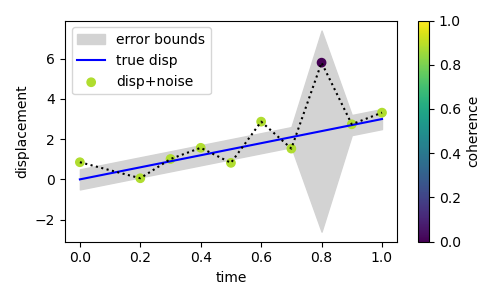

In [9]:
# plot it
plt.figure(figsize=(5,3),tight_layout=True)
plt.fill_between(t,D+Sig,D-Sig,color='lightgray',label='error bounds')
plt.plot(t,D,color='blue',label='true disp')
plt.plot(t,DN,'k:',)
plt.scatter(t,DN,c=coh,label='disp+noise',vmin=0.0,vmax=1.0) # only plotting one iteration of noise 
plt.legend(loc='upper left'); plt.colorbar(label='coherence')
plt.ylabel('displacement'); plt.xlabel('time')
plt.show()

In [10]:
# inversions using displacements (slope and intercept)
Gd = np.hstack((t.reshape((nd,1)),(np.ones((nd,1))))) # 10x2
print('Gd: \t'+str(np.shape(Gd)))
Ggdb = ((np.linalg.inv(Gd.T.dot(np.linalg.inv(Sigm**2)).dot(Gd))).dot(Gd.T)).dot(np.linalg.inv(Sigm**2))    # weighted, 2x10 
print('Ggdb: \t'+str(np.shape(Ggdb)))
# now do the inversion for displacement, followed by inversion for V
d = DN.reshape(nd,1) # first iteration of adding noise to igram data              # constraint
print('d: \t'+str(np.shape(d)))

diags = np.ones((nd-1))
Gint = np.diag(diags,1)-1*np.eye(nd)
Gint = Gint[0:-1,:]
print('Gint: '+str(np.shape(Gint)))
ints = Gint.dot(d)  
#ints = ints+N2
print('ints: '+str(np.shape(ints)))  
to_stack = (np.ones((nd,1))/(nd-1)).T    # avg=0 constraint 
G1 = np.vstack((Gint,to_stack))
print('G1: '+str(np.shape(G1)))
Gg1b = ((np.linalg.inv(G1.T.dot(np.linalg.inv(Sigm**2)).dot(G1))).dot(G1.T)).dot(np.linalg.inv(Sigm**2))    # weighted      
print('Gg1b: '+str(np.shape(Gg1b)))         
Db = Gg1b.dot(np.vstack((ints,0))) # constraint
print('Db: '+str(np.shape(Db)))
Vdb = Ggdb.dot(Db)  
print('Vdb: '+str(np.shape(Vdb)))              # actually 2 parameters, slope and intercept 
covVb = G1.dot((Sigm**2)).dot(G1.T)

print('weighted V from disps: '+str(Vdb[0][0]))
print('intercept: '+str(Vdb[1][0]))
#print('inv disp, then V with sigma: '+str(np.sqrt(covVb[0,0]))) # not sure what this means 

line = t*Vdb[0][0] + Vdb[1][0]

# regular (non-weighted) polyfit
m,b = np.polyfit(t,DN,1)
line_unweighted = m*t+b 

Gd: 	(10, 2)
Ggdb: 	(2, 10)
d: 	(10, 1)
Gint: (9, 10)
ints: (9, 1)
G1: (10, 10)
Gg1b: (10, 10)
Db: (10, 1)
Vdb: (2, 1)
weighted V from disps: 2.8158817837255756
intercept: -1.8517624807772606


In [11]:
difference = line[0] - Db[0,0]
print(difference)


-0.6472052062312792


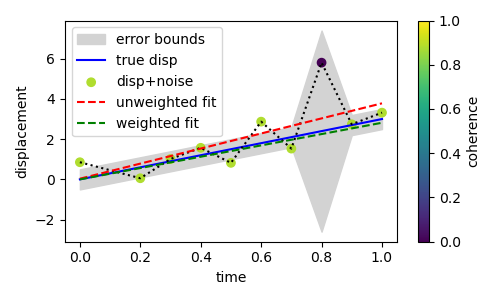

In [12]:
plt.figure(figsize=(5,3),tight_layout='TRUE')
plt.fill_between(t,D+Sig,D-Sig,color='lightgray',label='error bounds')
plt.plot(t,D,'b-',label='true disp')
plt.plot(t,d,'k:') # only plotting one iteration of noise 
plt.scatter(t,DN,c=coh,vmin=0.0,vmax=1.0,label='disp+noise')
plt.plot(t,line_unweighted,'r--',label='unweighted fit')
plt.plot(t,line-line[0],'g--',label='weighted fit')
plt.xlabel('time'); plt.ylabel('displacement'); plt.colorbar(label='coherence')
plt.legend()
plt.show()